In [1]:
from data import load_data, data_prep
from train import train, objective, build_hidden_mults
from data_openml import DataSetCatCon
from torch.utils.data import DataLoader
from models import SAINT
import torch.optim as optim
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import pandas as pd
import optuna
import numpy as np
import torch
from optuna.exceptions import TrialPruned

##################################
MAX_FEATURES=100
N_TRIALS=20
N_ROWS = None    # Set to None to use all rows
##################################

X, y = load_data(n_rows=N_ROWS)

#========> Set a random seed for reproducibility
np.random.seed(239048)
cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std, continuous_mean_std = data_prep(X, y, datasplit=[.65, .15, .2])

/home/carlotapuente/anaconda3/envs/saint_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# select best fingerprints 
X_catboost = pd.DataFrame(X_train["data"])
categorical_columns = [X_catboost.columns[i] for i in cat_idxs]
for col in categorical_columns:
    X_catboost[col] = X_catboost[col].astype("int")
model2 = CatBoostRegressor(cat_features=cat_idxs)  # FIXME
#================> should use only train data to avoid data leakage
model2.fit(X_catboost, y_train["data"])
#==================> To only select based on max_features, set threshold=-np.inf.
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html
fgpts_selector = SelectFromModel(model2, prefit=True, threshold=-np.inf, max_features=MAX_FEATURES)


Learning rate set to 0.023884
0:	learn: 16.3979779	total: 49.8ms	remaining: 49.7s
1:	learn: 16.3114375	total: 50.4ms	remaining: 25.1s
2:	learn: 16.1705095	total: 50.9ms	remaining: 16.9s
3:	learn: 16.0060325	total: 51.3ms	remaining: 12.8s
4:	learn: 15.8594309	total: 51.8ms	remaining: 10.3s
5:	learn: 15.7472899	total: 52.2ms	remaining: 8.64s
6:	learn: 15.6244287	total: 52.6ms	remaining: 7.46s
7:	learn: 15.4576209	total: 53.1ms	remaining: 6.58s
8:	learn: 15.3522995	total: 53.6ms	remaining: 5.9s
9:	learn: 15.2059752	total: 54.1ms	remaining: 5.35s
10:	learn: 15.0489753	total: 54.6ms	remaining: 4.91s
11:	learn: 14.9384029	total: 55.1ms	remaining: 4.53s
12:	learn: 14.7986907	total: 55.6ms	remaining: 4.22s
13:	learn: 14.6641281	total: 56.2ms	remaining: 3.96s
14:	learn: 14.5618989	total: 56.7ms	remaining: 3.72s
15:	learn: 14.4506481	total: 57.4ms	remaining: 3.53s
16:	learn: 14.3002810	total: 58.2ms	remaining: 3.37s
17:	learn: 14.1708535	total: 58.8ms	remaining: 3.21s
18:	learn: 14.0293094	total

In [3]:
features_mask = fgpts_selector.get_support()
# Force that both m/z and adduct are always selected 
features_mask[0] = True
features_mask[1] = True
# Ensure m/z is always selected
assert features_mask[0] == True
# Ensure adduct is always selected
assert features_mask[1] == True

n_features = X_train["data"][:, features_mask].shape[1]

cat_idxs = list(range(1, n_features))
print(cat_idxs)
cat_dims = cat_dims[:n_features]
print(cat_dims)

X_train["data"] = X_train["data"][:, features_mask]
X_train["mask"] = X_train["mask"][:, features_mask]
X_valid["data"] = X_valid["data"][:, features_mask]
X_valid["mask"] = X_valid["mask"][:, features_mask]
X_test["data"] = X_test["data"][:, features_mask]
X_test["mask"] = X_test["mask"][:, features_mask]



[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1 3 2 2 2 2 2 2 2 2]


In [4]:
train_ds = DataSetCatCon(X_train, y_train, cat_idxs,'reg',continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=256, shuffle=True,num_workers=4)

valid_ds = DataSetCatCon(X_valid, y_valid, cat_idxs,'reg', continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=256, shuffle=False,num_workers=4)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs,'reg', continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=256, shuffle=False,num_workers=4)

In [8]:
# select best hyperparameters

storage_name = "sqlite:///saint.db"
study1 = optuna.create_study(study_name="step-1", storage=storage_name, load_if_exists=True)

study1.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, first_trial=True), n_trials=N_TRIALS, catch=(optuna.exceptions.OptunaError, MemoryError))
optim_params1 = study1.best_params 

lr = optim_params1['lr']
wd = optim_params1['weight_decay']
epochs = optim_params1['epochs']

[I 2024-06-21 11:37:26,755] Using an existing study with name 'step-1' instead of creating a new one.


lr: 0.00042959779266501293, weight_decay: 0.036341243710070976, epochs: 18, dim: 32, depth: 1, heads: 4, attn_dropout: 0.8, ff_dropout: 0.8, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine


[I 2024-06-21 11:37:27,342] Trial 83 pruned. 


lr: 0.0008113213001007606, weight_decay: 0.026325966595170405, epochs: 14, dim: 32, depth: 1, heads: 4, attn_dropout: 0.8, ff_dropout: 0.8, mlp_hidden_mults: (4, 2), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine


[I 2024-06-21 11:37:27,956] Trial 84 pruned. 


In [9]:
# Create an unique id for step-2 based on the best hyperparameters from step-1
# unique_id = hash("{}-{}".format(str(lr), str(wd), str(epochs)))
unique_id = hash("{}-{}".format(str(lr), str(wd)))
study = optuna.create_study(
    study_name=f"id_{unique_id}_step-2",
    storage=storage_name,
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=10, reduction_factor=3
    ),
    load_if_exists=True
)

study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, lr=lr, wd=wd, epochs=epochs), n_trials=N_TRIALS, catch=(optuna.exceptions.OptunaError, MemoryError))

optim_params = study.best_params 

[I 2024-06-21 11:37:31,173] Using an existing study with name 'id_327041996787014035_step-2' instead of creating a new one.


lr: 0.0027339479979181466, weight_decay: 0.08326859110739228, epochs: 10, dim: 17, depth: 2, heads: 7, attn_dropout: 0.8347395196694449, ff_dropout: 0.7836934673984151, mlp_hidden_mults: (16, 8), final_mlp_style: common, optimizer: SGD, scheduler: cosine


[I 2024-06-21 11:37:32,398] Trial 2 pruned. 


lr: 0.0027339479979181466, weight_decay: 0.08326859110739228, epochs: 10, dim: 50, depth: 3, heads: 3, attn_dropout: 0.8346257997727784, ff_dropout: 0.5031863457321899, mlp_hidden_mults: (16, 8), final_mlp_style: sep, optimizer: AdamW, scheduler: cosine


[I 2024-06-21 11:37:34,100] Trial 3 pruned. 


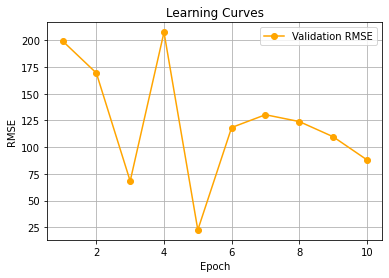

In [7]:
optim_params['mlp_hidden_mults'] = build_hidden_mults(optim_params['mlp_hidden_mults'])  

model = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(con_idxs),                
    dim = optim_params['dim'],                         
    dim_out = 1,                       
    depth = optim_params['depth'],                        
    heads = optim_params['heads'],                         
    attn_dropout = optim_params['attn_dropout'],             
    ff_dropout = optim_params['ff_dropout'],                  
    mlp_hidden_mults = optim_params['mlp_hidden_mults'],       
    cont_embeddings = 'MLP',
    attentiontype = 'colrow',
    final_mlp_style = optim_params['final_mlp_style'],
    y_dim = 1 # porque es regression 
)


if optim_params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=optim_params1['lr'], momentum=0.9, weight_decay=optim_params1['weight_decay'])
elif optim_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=optim_params1['lr'])
elif optim_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(model.parameters(),lr=optim_params1['lr'])

if optim_params['scheduler'] == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
elif optim_params['scheduler'] == 'linear':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs // 2.667, epochs // 1.6, epochs // 1.142], gamma=0.1)

valid_rmse = train(model, optimizer, scheduler, epochs, trainloader, testloader, plot=True)

In [ ]:
# channels:
#     - anaconda
#     - pytorch
#     - rwest
#     - vgauthier
#     - conda-forge
#     - defaults
#     - ostrokach
#   dependencies:
#     - _libgcc_mutex=0.1=conda_forge
#     - _openmp_mutex=4.5=1_gnu
#     - _py-xgboost-mutex=2.0=cpu_0
#     - anyio=3.2.1=py38h578d9bd_0
#     - argh=0.26.2=pyh9f0ad1d_1002
#     - argon2-cffi=20.1.0=py38h497a2fe_2
#     - async_generator=1.10=py_0
#     - attrs=21.2.0=pyhd8ed1ab_0
#     - babel=2.9.1=pyh44b312d_0
#     - backcall=0.2.0=pyh9f0ad1d_0
#     - backports=1.0=py_2
#     - backports.functools_lru_cache=1.6.4=pyhd8ed1ab_0
#     - blas=1.0=mkl
#     - bleach=3.3.1=pyhd8ed1ab_0
#     - brotlipy=0.7.0=py38h497a2fe_1001
#     - bzip2=1.0.8=h7f98852_4
#     - ca-certificates=2021.5.30=ha878542_0
#     - certifi=2021.5.30=py38h578d9bd_0
#     - cffi=1.14.5=py38ha65f79e_0
#     - chardet=4.0.0=py38h578d9bd_1
#     - click=8.0.1=py38h578d9bd_0
#     - configparser=5.0.2=pyhd8ed1ab_0
#     - cryptography=3.4.7=py38ha5dfef3_0
#     - cudatoolkit=11.1.1=h6406543_8
#     - cycler=0.10.0=py_2
#     - dbus=1.13.18=hb2f20db_0
#     - debugpy=1.3.0=py38h709712a_0
#     - decorator=5.0.9=pyhd8ed1ab_0
#     - defusedxml=0.7.1=pyhd8ed1ab_0
#     - docker-pycreds=0.4.0=py_0
#     - einops=0.3.0=py_0
#     - entrypoints=0.3=pyhd8ed1ab_1003
#     - expat=2.4.1=h9c3ff4c_0
#     - ffmpeg=4.3=hf484d3e_0
#     - fontconfig=2.13.1=hba837de_1005
#     - freetype=2.10.4=h0708190_1
#     - gettext=0.19.8.1=h0b5b191_1005
#     - gitdb=4.0.7=pyhd8ed1ab_0
#     - gitpython=3.1.17=pyhd8ed1ab_0
#     - glib=2.68.3=h9c3ff4c_0
#     - glib-tools=2.68.3=h9c3ff4c_0
#     - gmp=6.2.1=h58526e2_0
#     - gnutls=3.6.13=h85f3911_1
#     - gql=0.1.0=py_0
#     - graphql-core=3.1.5=pyhd8ed1ab_0
#     - gst-plugins-base=1.14.0=hbbd80ab_1
#     - gstreamer=1.14.0=h28cd5cc_2
#     - icu=58.2=hf484d3e_1000
#     - idna=2.10=pyh9f0ad1d_0
#     - importlib-metadata=4.6.1=py38h578d9bd_0
#     - intel-openmp=2021.2.0=h06a4308_610
#     - ipdb=0.13.9=pyhd8ed1ab_0
#     - ipykernel=6.0.2=py38hd0cf306_0
#     - ipython=7.25.0=py38hd0cf306_1
#     - ipython_genutils=0.2.0=py_1
#     - jedi=0.18.0=py38h578d9bd_2
#     - jinja2=3.0.1=pyhd8ed1ab_0
#     - joblib=0.17.0=py_0
#     - jpeg=9b=h024ee3a_2
#     - json5=0.9.5=pyh9f0ad1d_0
#     - jsonschema=3.2.0=pyhd8ed1ab_3
#     - jupyter_client=6.1.12=pyhd8ed1ab_0
#     - jupyter_core=4.7.1=py38h578d9bd_0
#     - jupyter_server=1.9.0=pyhd8ed1ab_0
#     - jupyterlab=3.0.16=pyhd8ed1ab_0
#     - jupyterlab_pygments=0.1.2=pyh9f0ad1d_0
#     - jupyterlab_server=2.6.1=pyhd8ed1ab_0
#     - kiwisolver=1.3.1=py38h1fd1430_1
#     - lame=3.100=h7f98852_1001
#     - lcms2=2.12=h3be6417_0
#     - ld_impl_linux-64=2.35.1=hea4e1c9_2
#     - liac-arff=2.5.0=pyhd8ed1ab_1
#     - libffi=3.3=h58526e2_2
#     - libgcc-ng=9.3.0=h2828fa1_19
#     - libgfortran-ng=7.3.0=hdf63c60_0
#     - libglib=2.68.3=h3e27bee_0
#     - libgomp=9.3.0=h2828fa1_19
#     - libiconv=1.16=h516909a_0
#     - libidn2=2.3.1=h7f98852_0
#     - libpng=1.6.37=h21135ba_2
#     - libprotobuf=3.17.2=h780b84a_0
#     - libsodium=1.0.18=h36c2ea0_1
#     - libstdcxx-ng=9.3.0=h6de172a_19
#     - libtiff=4.2.0=h85742a9_0
#     - libunistring=0.9.10=h14c3975_0
#     - libuuid=2.32.1=h7f98852_1000
#     - libuv=1.41.0=h7f98852_0
#     - libwebp-base=1.2.0=h7f98852_2
#     - libxcb=1.13=h7f98852_1003
#     - libxgboost=1.4.0=h9c3ff4c_0
#     - libxml2=2.9.12=h03d6c58_0
#     - lz4-c=1.9.3=h9c3ff4c_0
#     - markupsafe=2.0.1=py38h497a2fe_0
#     - matplotlib=3.4.2=py38h578d9bd_0
#     - matplotlib-base=3.4.2=py38hcc49a3a_0
#     - matplotlib-inline=0.1.2=pyhd8ed1ab_2
#     - mistune=0.8.4=py38h497a2fe_1004
#     - mkl=2021.2.0=h06a4308_296
#     - mkl-service=2.4.0=py38h497a2fe_0
#     - mkl_fft=1.3.0=py38h42c9631_2
#     - mkl_random=1.2.2=py38h1abd341_0
#     - nbclassic=0.3.1=pyhd8ed1ab_1
#     - nbclient=0.5.3=pyhd8ed1ab_0
#     - nbconvert=6.1.0=py38h578d9bd_0
#     - nbformat=5.1.3=pyhd8ed1ab_0
#     - ncurses=6.2=h58526e2_4
#     - nest-asyncio=1.5.1=pyhd8ed1ab_0
#     - nettle=3.6=he412f7d_0
#     - ninja=1.10.2=h4bd325d_0
#     - notebook=6.4.0=pyha770c72_0
#     - numpy=1.20.2=py38h2d18471_0
#     - numpy-base=1.20.2=py38hfae3a4d_0
#     - nvidia-ml=7.352.0=py_0
#     - olefile=0.46=pyh9f0ad1d_1
#     - openh264=2.1.1=h780b84a_0
#     - openml=0.11.0=pyhd8ed1ab_0
#     - openssl=1.1.1k=h7f98852_0
#     - packaging=21.0=pyhd8ed1ab_0
#     - pandas=1.2.4=py38h1abd341_0
#     - pandoc=2.14.0.3=h7f98852_0
#     - pandocfilters=1.4.2=py_1
#     - parso=0.8.2=pyhd8ed1ab_0
#     - pathtools=0.1.2=py_1
#     - pcre=8.45=h9c3ff4c_0
#     - pexpect=4.8.0=pyh9f0ad1d_2
#     - pickleshare=0.7.5=py_1003
#     - pillow=8.2.0=py38he98fc37_0
#     - pip=21.1.2=pyhd8ed1ab_0
#     - prometheus_client=0.11.0=pyhd8ed1ab_0
#     - promise=2.3=py38h578d9bd_3
#     - prompt-toolkit=3.0.19=pyha770c72_0
#     - protobuf=3.17.2=py38h709712a_0
#     - psutil=5.8.0=py38h497a2fe_1
#     - pthread-stubs=0.4=h36c2ea0_1001
#     - ptyprocess=0.7.0=pyhd3deb0d_0
#     - py-xgboost=1.4.0=py38h578d9bd_0
#     - pycparser=2.20=pyh9f0ad1d_2
#     - pygments=2.9.0=pyhd8ed1ab_0
#     - pyopenssl=20.0.1=pyhd8ed1ab_0
#     - pyparsing=2.4.7=pyh9f0ad1d_0
#     - pyqt=5.9.2=py38h05f1152_4
#     - pyrsistent=0.17.3=py38h497a2fe_2
#     - pysocks=1.7.1=py38h578d9bd_3
#     - python=3.8.10=h49503c6_1_cpython
#     - python-dateutil=2.8.1=py_0
#     - python-wget=3.2=py_0
#     - python_abi=3.8=1_cp38
#     - pytorch=1.8.1=py3.8_cuda11.1_cudnn8.0.5_0
#     - pytz=2021.1=pyhd8ed1ab_0
#     - pyyaml=5.4.1=py38h497a2fe_0
#     - pyzmq=22.1.0=py38h2035c66_0
#     - qt=5.9.7=h5867ecd_1
#     - readline=8.1=h46c0cb4_0
#     - requests=2.25.1=pyhd3deb0d_0
#     - requests-unixsocket=0.2.0=py_0
#     - scikit-learn=0.23.2=py38h0573a6f_0
#     - scipy=1.6.2=py38had2a1c9_1
#     - seaborn=0.11.0=py_0
#     - send2trash=1.7.1=pyhd8ed1ab_0
#     - sentry-sdk=1.1.0=pyhd8ed1ab_0
#     - setuptools=49.6.0=py38h578d9bd_3
#     - shortuuid=1.0.1=py38h578d9bd_4
#     - sip=4.19.13=py38he6710b0_0
#     - six=1.16.0=pyh6c4a22f_0
#     - smmap=3.0.5=pyh44b312d_0
#     - sniffio=1.2.0=py38h578d9bd_1
#     - sqlite=3.35.5=h74cdb3f_0
#     - subprocess32=3.5.4=py_1
#     - terminado=0.10.1=py38h578d9bd_0
#     - testpath=0.5.0=pyhd8ed1ab_0
#     - threadpoolctl=2.1.0=pyh5ca1d4c_0
#     - tk=8.6.10=h21135ba_1
#     - torchvision=0.9.1=py38_cu111
#     - tornado=6.1=py38h497a2fe_1
#     - traitlets=5.0.5=py_0
#     - typing_extensions=3.7.4.3=py_0
#     - urllib3=1.26.5=pyhd8ed1ab_0
#     - wandb=0.10.31=pyhd8ed1ab_0
#     - watchdog=0.10.4=py38h578d9bd_0
#     - wcwidth=0.2.5=pyh9f0ad1d_2
#     - webencodings=0.5.1=py_1
#     - websocket-client=0.57.0=py38h578d9bd_4
#     - wget=1.20.1=h22169c7_0
#     - wheel=0.36.2=pyhd3deb0d_0
#     - xgboost=1.4.0=py38h578d9bd_0
#     - xmltodict=0.12.0=py_0
#     - xorg-libxau=1.0.9=h7f98852_0
#     - xorg-libxdmcp=1.1.3=h7f98852_0
#     - xz=5.2.5=h516909a_1
#     - yaml=0.2.5=h516909a_0
#     - zeromq=4.3.4=h9c3ff4c_0
#     - zipp=3.5.0=pyhd8ed1ab_0
#     - zlib=1.2.11=h516909a_1010
#     - zstd=1.4.9=ha95c52a_0